In [1]:
!pip install gymnasium

In [2]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
import random
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# Define model
class QNetwork(nn.Module):

    def __init__(self, state_shape, h1_nodes, action_space_size, seed):
        """ state_shape (int): Dimension of each state
            h1_nodes (int): Number of nodes in first hidden layer
            action_space_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
         ## add three fully connected layers using nn.Linear()
         #-----------------add code here-----------------------
        self.fc1 = nn.Linear(state_shape, h1_nodes)       # First hidden layer
        self.fc2 = nn.Linear(h1_nodes, h1_nodes // 2)     # Second hidden layer
        self.fc3 = nn.Linear(h1_nodes // 2, action_space_size)  # Output layer


    def forward(self, state):
      # define the forward propagation  by adding the relu() activation function between layers
      #-----------------add code here----------------------- 
        x = F.relu(self.fc1(state))   # First hidden layer with ReLU activation
        x = F.relu(self.fc2(x))       # Second hidden layer with ReLU activation
        x = self.fc3(x)               # Output layer (no activation for Q-values)
        return x

In [6]:
import random
from collections import deque

class ReplayMemory():
    def __init__(self, maxlen, batch_size):
        self.memory = deque([], maxlen=maxlen)
        self.batch_size = batch_size

    def append(self, experience):
        self.memory.append(experience)

    def sample(self):
        # Randomly sample a batch of experiences from memory
        return random.sample(self.memory, k=self.batch_size)

    def __len__(self):
        return len(self.memory)


In [21]:

class DQAgent:
    """Interacts with and learns from the environment."""

    def __init__(self, state_shape, action_space_size, seed, h1_nodes=64, learning_rate=5e-4, replay_memory_size=int(1e5), batch_size=64, UPDATE_EVERY=20, LEARN_EVERY=4, GAMMA=0.99):
        """Initialize an Agent object."""
        
        self.state_shape = state_shape
        self.action_space_size = action_space_size
        self.seed = random.seed(seed)
        self.GAMMA = GAMMA
        self.UPDATE_EVERY = UPDATE_EVERY
        self.LEARN_EVERY = LEARN_EVERY
        self.h1_nodes = h1_nodes
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.replay_memory_size = replay_memory_size

        # Q-Network
        self.local_dqn = QNetwork(state_shape, h1_nodes, action_space_size, seed).to(device)
        self.target_dqn = QNetwork(state_shape, h1_nodes, action_space_size, seed).to(device)

        # Optimizer
        self.optimizer = optim.Adam(self.local_dqn.parameters(), lr=self.learning_rate)

        # Replay memory
        self.memory = ReplayMemory(self.replay_memory_size, self.batch_size)

        # Initialize time steps for learning and updating target network
        self.l_step = 0
        self.t_step = 0

    def state_to_dqn_input(self, state) -> torch.Tensor:
        return torch.from_numpy(state).float().unsqueeze(0).to(device)

    def act(self, state, eps=0.):
        state = self.state_to_dqn_input(state)
        if random.random() > eps:
            with torch.no_grad():
                q_values = self.local_dqn(state)
            action = torch.argmax(q_values).item()  # Best action from Q-network
        else:
            action = random.choice(np.arange(self.action_space_size))  # Random action
        return action

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.append((state, action, reward, next_state, done))

        # If enough samples are available in memory, get random subset and learn
        self.l_step = (self.l_step + 1) % self.LEARN_EVERY
        if self.l_step == 0 and len(self.memory) > self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences)

        # Copy local network to target network every UPDATE_EVERY time steps
        self.t_step = (self.t_step + 1) % self.UPDATE_EVERY
        if self.t_step == 0:
            self.target_dqn.load_state_dict(self.local_dqn.state_dict())

    def learn(self, experiences):
        q_target_list = []
        q_expected_list = []

        # Obtain random minibatch of tuples from ReplayMemory
        for state, action, reward, next_state, done in experiences:
            # Convert state and next_state to tensors
            state = torch.from_numpy(state).float().to(device)  # No need to unsqueeze for a single experience
            next_state = torch.from_numpy(next_state).float().to(device)  # No need to unsqueeze for a single experience
            action = torch.tensor(action).long().to(device)  # Convert action to tensor
            reward = torch.tensor(reward).float().to(device)  # Convert reward to tensor

            # Compute the target Q value
            if done:
                q_target = reward
            else:
                with torch.no_grad():
                    q_target_next = self.target_dqn(next_state).max(1)[0]  # Get max Q value from target
                q_target = reward + (self.GAMMA * q_target_next)

            # Calculate Q-expected (from local network)
            q_local = self.local_dqn(state).gather(1, action)  # Use action directly

            q_target_list.append(q_target)
            q_expected_list.append(q_local)

        # Loss calculation (Mean squared error)
        loss = F.mse_loss(torch.stack(q_expected_list), torch.stack(q_target_list))  # Stack for batch processing
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


In [23]:
def dqn_train(agent, n_episodes=300, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon

    for i_episode in tqdm(range(1, n_episodes + 1)):
        state = env.reset()[0]
        score = 0

        for t in range(max_t):
            # select an action
            action = agent.act(state, eps)

            # apply the selected action
            next_state, reward, done, _, _ = env.step(action)

            # store the current experience
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward
            if done:
                break
                
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay * eps)  # decrease epsilon

        if i_episode % 50 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

    torch.save(agent.local_dqn.state_dict(), 'checkpoint.pth')
    return scores


In [24]:
env = gym.make('CartPole-v1')
print(env.reset())

print('State shape: ', env.observation_space.shape[0])
print('Number of actions: ', env.action_space.n)

(array([0.03930597, 0.0099737 , 0.04491559, 0.04826724], dtype=float32), {})
State shape:  4
Number of actions:  2


In [25]:
agent = DQAgent(state_shape=env.observation_space.shape[0], action_space_size=env.action_space.n, seed=0)
scores = dqn_train(agent)

 17%|█▋        | 51/300 [00:14<00:51,  4.84it/s]

Episode 50	Average Score: 21.58


 34%|███▎      | 101/300 [00:25<00:36,  5.46it/s]

Episode 100	Average Score: 18.42


 50%|█████     | 151/300 [00:35<00:30,  4.93it/s]

Episode 150	Average Score: 14.79


 67%|██████▋   | 200/300 [00:51<00:46,  2.16it/s]

Episode 200	Average Score: 19.00


 83%|████████▎ | 250/300 [01:36<00:46,  1.09it/s]

Episode 250	Average Score: 43.00


100%|██████████| 300/300 [02:50<00:00,  1.76it/s]

Episode 300	Average Score: 83.41


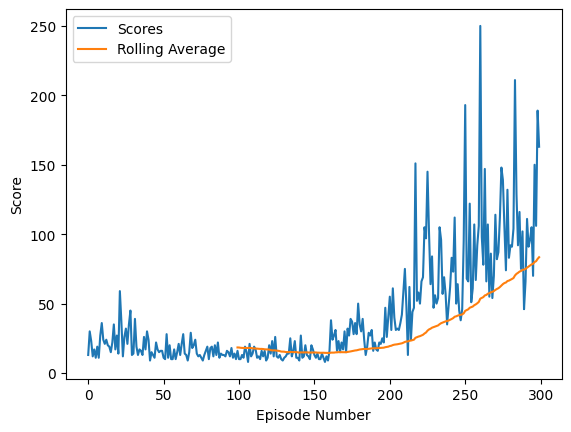

In [26]:
scores = pd.Series(scores, name="scores")
scores.describe()
fig, ax = plt.subplots(1, 1)
_ = scores.plot(ax=ax, label="Scores")
_ = (scores.rolling(window=100)
           .mean()
           .rename("Rolling Average")
           .plot(ax=ax))
ax.legend()
_ = ax.set_xlabel("Episode Number")
_ = ax.set_ylabel("Score")